In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Chargement des donn√©es
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

# Aper√ßu initial
print(f"Nombre de lignes : {len(df)}")
print("\n5 premi√®res lignes :")
print(df.head())
print("\nInformations sur les colonnes :")
print(df.info())

Nombre de lignes : 541909

5 premi√®res lignes :
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns

In [2]:
# Suppression des lignes sans CustomerID
df = df.dropna(subset=['CustomerID'])



# Filtrage des quantit√©s et prix positifs
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Cr√©ation de la colonne MontantTotal
df['MontantTotal'] = df['Quantity'] * df['UnitPrice']

# V√©rification des doublons
print(f"\nNombre de doublons : {df.duplicated().sum()}")
df = df.drop_duplicates()


Nombre de doublons : 5192



Statistiques descriptives :
            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 12:02:00       1.950000   
75%        12.000000            2011-10-20 12:53:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.492832                            NaN      22.241836   

          CustomerID   MontantTotal  
count  392692.000000  392692.000000  
mean    15287.843865      22.631500  
min     12346.000000       0.001000  
25%     13955.000000       4.950000  
50%     15150.000000      12.450000  
75%     16791.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.539549     311.099224 

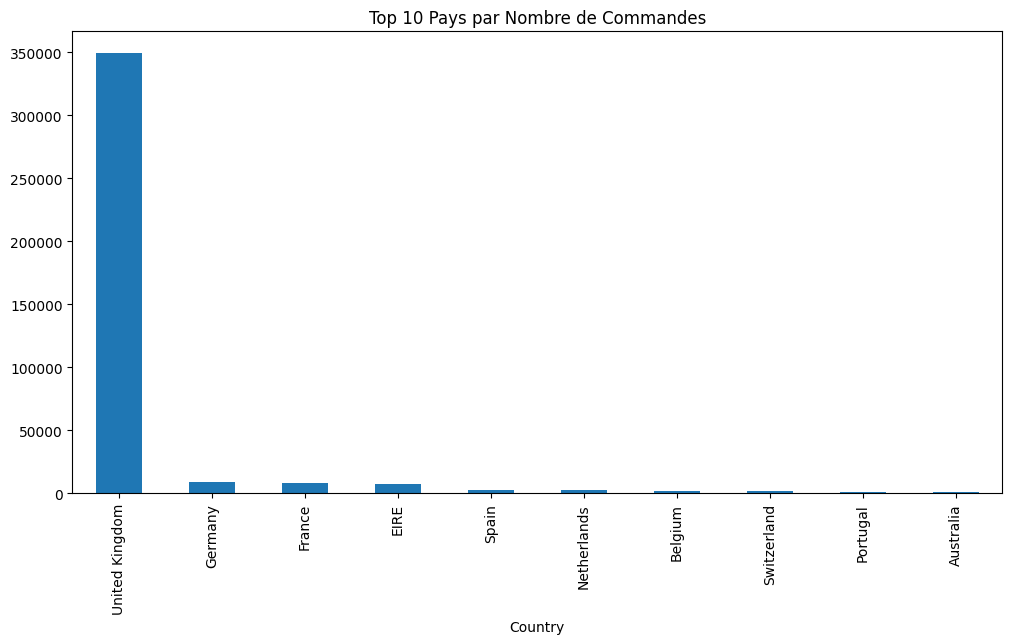

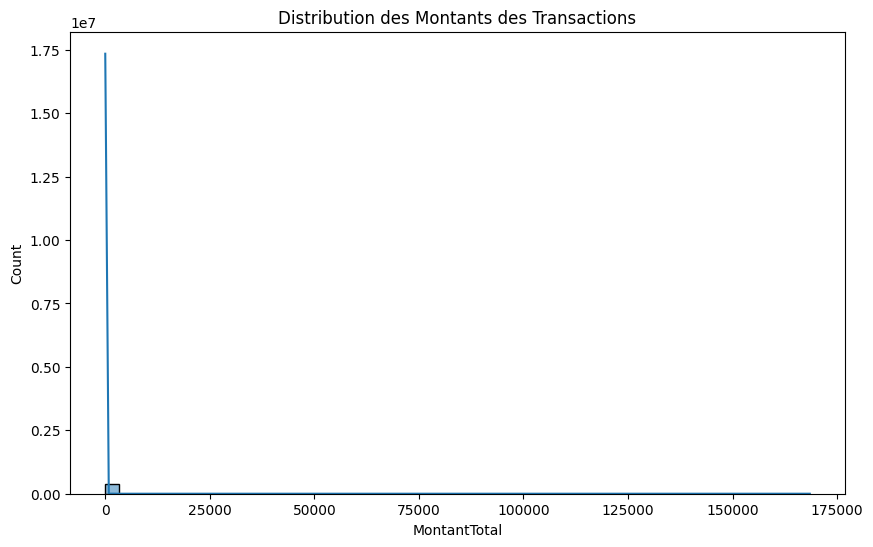

In [3]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

# Top 10 produits les plus vendus
top_products = df['Description'].value_counts().head(10)
print("\nTop 10 produits :")
print(top_products)

# R√©partition par pays
plt.figure(figsize=(12,6))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Pays par Nombre de Commandes')
plt.show()

# Distribution des montants
plt.figure(figsize=(10,6))
sns.histplot(df['MontantTotal'], bins=50, kde=True)
plt.title('Distribution des Montants des Transactions')
plt.show()

In [4]:
# Date de r√©f√©rence (derni√®re date + 1 jour)
date_reference = df['InvoiceDate'].max() + timedelta(days=1)

# Calcul RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (date_reference - x.max()).days,  # R√©cence
    'InvoiceNo': 'nunique',  # Fr√©quence
    'MontantTotal': 'sum'    # Montant
}).reset_index()

# Renommage des colonnes
rfm.columns = ['CustomerID', 'Recence', 'Frequence', 'Montant']

# Affichage des r√©sultats
print("\nExemple de donn√©es RFM :")
print(rfm.head())


Exemple de donn√©es RFM :
   CustomerID  Recence  Frequence   Montant
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


In [5]:
from sklearn.preprocessing import StandardScaler

# S√©lection des variables
rfm_data = rfm[['Recence', 'Frequence', 'Montant']]

# Normalisation
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recence', 'Frequence', 'Montant'])

# V√©rification
print("\nDonn√©es apr√®s normalisation :")
print(rfm_scaled.describe().round(2))


Donn√©es apr√®s normalisation :
       Recence  Frequence  Montant
count  4338.00    4338.00  4338.00
mean      0.00       0.00     0.00
std       1.00       1.00     1.00
min      -0.92      -0.43    -0.23
25%      -0.75      -0.43    -0.19
50%      -0.42      -0.30    -0.15
75%       0.49       0.09    -0.04
max       2.81      26.60    30.96


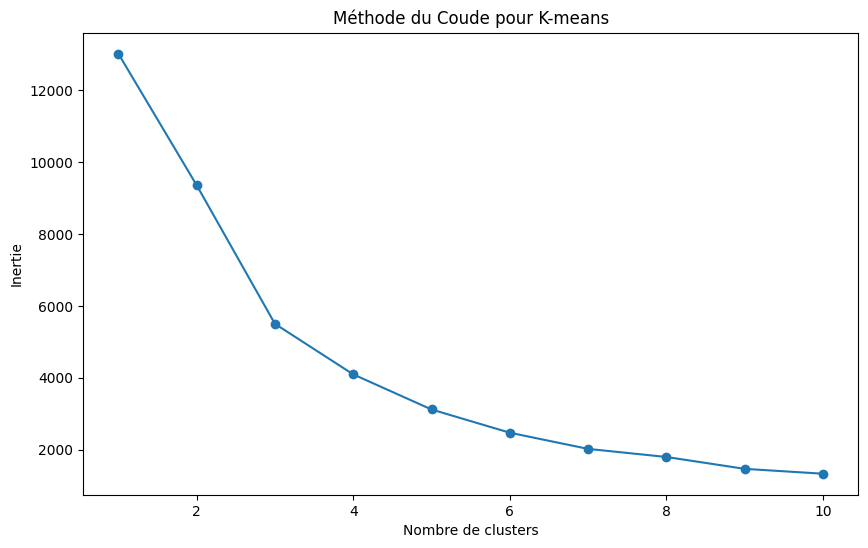


Statistiques par cluster (K-means) :
               Recence Frequence   Montant      
                  mean      mean      mean count
Cluster_Kmeans                                  
0                 43.7       3.7    1353.6  3054
1                248.1       1.6     478.8  1067
2                  7.4      82.5  127188.0    13
3                 15.5      22.3   12690.5   204


In [6]:
from sklearn.cluster import KMeans

# M√©thode du coude pour d√©terminer le nombre optimal de clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('M√©thode du Coude pour K-means')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

# Application avec 4 clusters (par exemple)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_Kmeans'] = kmeans.fit_predict(rfm_scaled)

# Analyse des clusters
cluster_stats = rfm.groupby('Cluster_Kmeans').agg({
    'Recence': 'mean',
    'Frequence': 'mean',
    'Montant': ['mean', 'count']
}).round(1)

print("\nStatistiques par cluster (K-means) :")
print(cluster_stats)

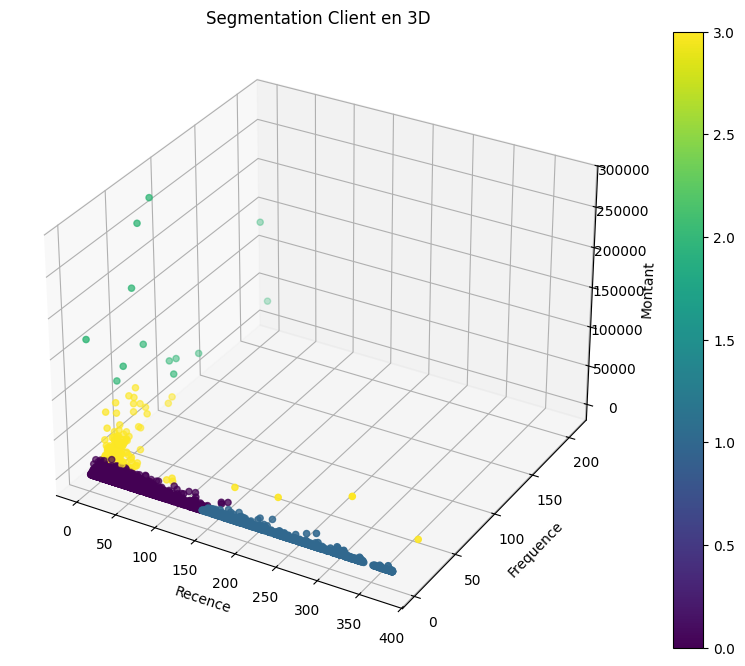

In [7]:
# Visualisation 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm['Recence'], rfm['Frequence'], rfm['Montant'], 
                     c=rfm['Cluster_Kmeans'], cmap='viridis')

ax.set_xlabel('Recence')
ax.set_ylabel('Frequence')
ax.set_zlabel('Montant')
plt.title('Segmentation Client en 3D')
plt.colorbar(scatter)
plt.show()

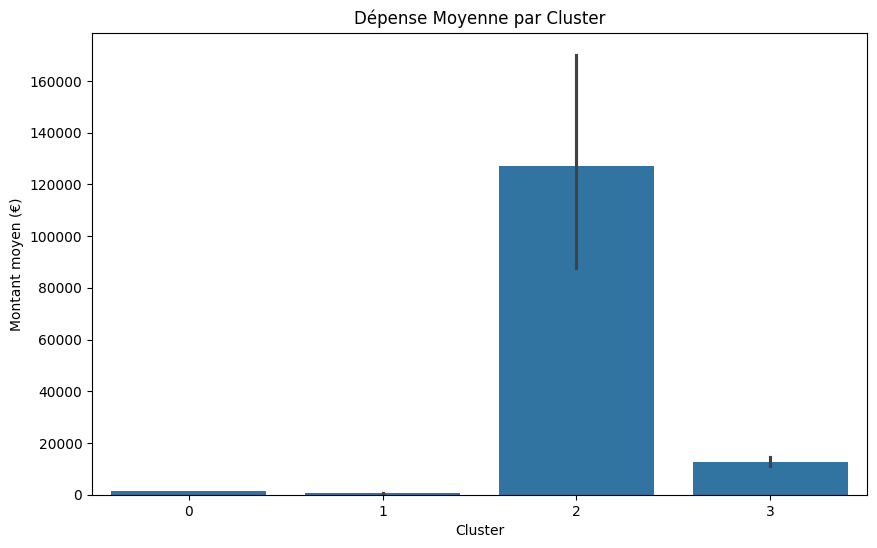

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=rfm, x='Cluster_Kmeans', y='Montant', estimator=np.mean)
plt.title('D√©pense Moyenne par Cluster')
plt.ylabel('Montant moyen (‚Ç¨)')
plt.xlabel('Cluster')
plt.show()

In [9]:
from mlxtend.frequent_patterns import apriori, association_rules

# Pr√©paration des donn√©es (produits par facture)
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

# Conversion en bool√©en (1 = achet√©, 0 = non achet√©)
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

# Application d'Apriori
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

# Extraction des r√®gles
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

# Affichage des 10 meilleures r√®gles
print("\nTop 10 r√®gles d'association :")
print(rules.head(10))

C:\Users\Selim\AppData\Local\Temp\ipykernel_9364\842937783.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 10 r√®gles d'association :
                                          antecedents  \
70  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
72  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
8                    (PINK REGENCY TEACUP AND SAUCER)   
63                   (PINK REGENCY TEACUP AND SAUCER)   
13                  (GREEN REGENCY TEACUP AND SAUCER)   
6                (GARDENERS KNEELING PAD CUP OF TEA )   
71  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
74                   (PINK REGENCY TEACUP AND SAUCER)   
12                 (ROSES REGENCY TEACUP AND SAUCER )   
4                              (DOLLY GIRL LUNCH BOX)   

                                          consequents  antecedent support  \
70                  (GREEN REGENCY TEACUP AND SAUCER)            0.023527   
72                 (ROSES REGENCY TEACUP AND SAUCER )            0.024822   
8                   (GREEN REGENCY TEACUP AND SAUCER)            0.030002   
63                 (ROSES REGENC

In [10]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

## 1. Pr√©paration des donn√©es
def prepare_transaction_data(df):
    """
    Transforme les donn√©es brutes en format transactionnel
    Retourne un DataFrame binaire (1=achet√©, 0=non achet√©)
    """
    # Grouper par facture et produit
    basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']
              .sum()
              .unstack()
              .reset_index()
              .fillna(0)
              .set_index('InvoiceNo'))
    
    # Convertir en bool√©en (optimis√© pour mlxtend)
    basket_bool = basket.map(lambda x: 1 if x > 0 else 0).astype(bool)
    
    return basket_bool

## 2. Extraction des itemsets fr√©quents
def find_frequent_itemsets(transaction_data, min_support=0.02):
    """
    Trouve les combinaisons de produits fr√©quentes
    min_support : seuil de fr√©quence minimum (2% par d√©faut)
    """
    return apriori(transaction_data, 
                  min_support=min_support,
                  use_colnames=True,  # Garde les noms de produits
                  max_len=4,  # Limite √† 4 articles max par combinaison
                  verbose=1)  # Affiche la progression

## 3. G√©n√©ration des r√®gles d'association
def generate_association_rules(frequent_itemsets, min_lift=1.5):
    """
    G√©n√®re les r√®gles √† partir des itemsets fr√©quents
    min_lift : seuil minimum pour la force de l'association
    """
    rules = association_rules(frequent_itemsets,
                            metric="lift",
                            min_threshold=min_lift)
    
    # Tri par confidence et lift d√©croissants
    return rules.sort_values(['confidence', 'lift'], ascending=[False, False])

## 4. Ex√©cution compl√®te
def full_analysis(df, min_support=0.02, min_lift=1.5, top_rules=10):
    """Pipeline complet d'analyse"""
    print("‚è≥ Pr√©paration des donn√©es...")
    transaction_data = prepare_transaction_data(df)
    
    print("üîç Recherche des itemsets fr√©quents...")
    frequent_itemsets = find_frequent_itemsets(transaction_data, min_support)
    
    print("üìä G√©n√©ration des r√®gles...")
    rules = generate_association_rules(frequent_itemsets, min_lift)
    
    # Filtrage des r√®gles triviales (1 seul produit)
    multi_item_rules = rules[rules['antecedents'].apply(len) > 1]
    
    print(f"\nüéØ Top {top_rules} r√®gles d'association :")
    return multi_item_rules.head(top_rules)

# Chargement des donn√©es (√† adapter)
# df = pd.read_excel("OnlineRetail.xlsx")

# Ex√©cution
if __name__ == "__main__":
    results = full_analysis(df, min_support=0.02, min_lift=2)
    print(results)

‚è≥ Pr√©paration des donn√©es...
üîç Recherche des itemsets fr√©quents...
Processing 1473 combinations | Sampling itemset size 32
üìä G√©n√©ration des r√®gles...

üéØ Top 10 r√®gles d'association :
                                          antecedents  \
70  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
72  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
71  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   

                           consequents  antecedent support  \
70   (GREEN REGENCY TEACUP AND SAUCER)            0.023527   
72  (ROSES REGENCY TEACUP AND SAUCER )            0.024822   
71    (PINK REGENCY TEACUP AND SAUCER)            0.029193   

    consequent support   support  confidence       lift  representativity  \
70            0.037287  0.021045    0.894495  23.989564               1.0   
72            0.042251  0.021045    0.847826  20.066300               1.0   
71            0.030002  0.021045    0.720887  24.027846               1.0   

    leverage